# Noisy and Low Light Image Enhancement with CNN



In [ ]:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy()

# print("REPLICAS: ", strategy.num_replicas_in_sync)


In [2]:
!pip install scikit-image

   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.8 MB 1.5 MB/s eta 0:00:09
   -- ------------------------------------- 0.8/12.8 MB 1.5 MB/s eta 0:00:09
   --- ------------------------------------ 1.0/12.8 MB 1.6 MB/s eta 0:00:08
   --- ------------------------------------ 1.0/12.8 MB 1.6 MB/s eta 0:00:08
   --- ------------------------------------ 1.0/12.8 MB 1.6 MB/s eta 0:00:08
   ---- ----------------------------------- 1.3/12.8 MB 958.5 kB/s eta 0:00:13
   ---- ----------------------------------- 1.3/12.8 MB 958.5 kB/s eta 0:00:13
   ---- ----------------------------------- 1.6/12.8 MB 783.9 kB/s eta 0:00:15
   ---- ----------------------------------- 1.6/12.8 MB 783.9 kB/s eta 0:00:15
   ----- ---------------------------------- 1.8/12.8 MB 798.8 kB/s eta 0:00:14
   ------ --------------------------------- 2.1/12.8 MB 815.6 kB/s eta 0:00:14
 

## Imports

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
import numpy as np
import pandas as pd
import os
import random
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from keras.preprocessing import image
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.layers import Dense, Dropout, Concatenate,Reshape, Conv2DTranspose,Conv2D, MaxPooling2D, LeakyReLU, UpSampling2D, Lambda
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from skimage.util import random_noise
from sklearn.preprocessing import MinMaxScaler
np.random.seed(1)
from skimage.exposure import adjust_gamma
import warnings
from tqdm import tqdm
warnings.simplefilter(action='ignore', category=FutureWarning)

mpl.rcParams['font.size'] = 10 # Set font size to 10
# mpl.rcParams['axes.edgecolor'] = 'white' # Set axis edge color to white
# mpl.rcParams['xtick.color'] = 'white' # Set x-axis tick color to white
# mpl.rcParams['ytick.color'] = 'white' # Set y-axis tick color to white


In [ ]:
os.environ['KAGGLE_USERNAME'] = "XXXX"

# username from the json file

os.environ['KAGGLE_KEY'] = "XXXXXXXXXXXXXXXXXXX"

# key from the json file

In [ ]:
!kaggle datasets download -d duttadebadri/image-classification

100% 2.34G/2.34G [00:25<00:00, 99.5MB/s]
100% 2.34G/2.34G [00:25<00:00, 99.8MB/s]


In [ ]:
!unzip -q "/content/image-classification.zip"

In [ ]:
InputPath="/content/images/images/travel and  adventure/"

### Let us define our function to add noise:

In [ ]:
def noisy(image, gamma):
  image = random_noise(image, mode='gaussian', var = 0.001, clip=True)
  image = adjust_gamma(image, gamma=gamma, gain=1)
  return image

## REAL IMAGE

(-0.5, 255.5, 255.5, -0.5)

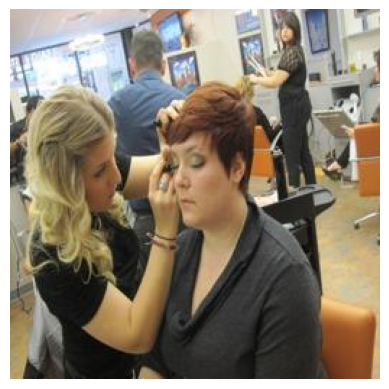

In [ ]:
img = cv.imread("/content/images/images/travel and  adventure/Places365_val_00005766.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.imshow(img/l)
plt.axis('off')


## IMAGE WITH NOISE(SALT AND PEPPER NOISE)

(1.0, 0.0)

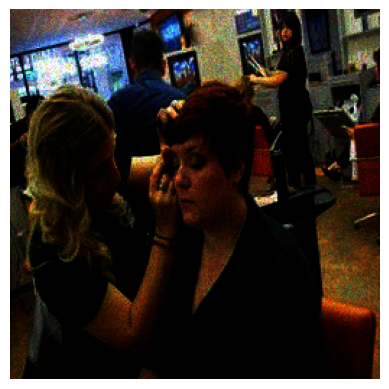

In [ ]:
img = np.array(img/255.0, dtype = np.float32)
Noise = noisy(img, 5)
plt.imshow(Noise)
plt.axis('off')
Noise.max(), Noise.min()

### Model:

In [4]:
def create_model(shape=(400, 400, 3)):
  in_ = Input(shape)
  p_in_ = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)

  model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(p_in_)
  model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
  model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
  model_2 = Conv2D(32,(1,1), activation='relu',padding='same',strides=1)(p_in_)
  model_add = add([model_1,model_2])
  model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
  model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
  model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
  model_add_2 = add([model_add,model_3])

  model_1 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
  model_1 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_1)
  model_1 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_1)
  model_2 = Conv2D(64,(1,1), activation='relu',padding='same',strides=1)(model_add_2)
  model_add = add([model_1,model_2])
  model_3 = Conv2D(128,(3,3), activation='relu',padding='same',strides=1)(model_add)
  model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_3)
  model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_3)
  model_add_2 = add([model_add,model_3])

  model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
  model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
  model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
  model_2 = Conv2D(32,(1,1), activation='relu',padding='same',strides=1)(model_add_2)
  model_add = add([model_1,model_2])
  model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
  model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
  model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
  model_add_2 = add([model_add,model_3])
  out_ = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
  Model_Enhancer = Model(inputs=in_, outputs=out_)
  return Model_Enhancer


In [5]:
def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim( y_true, y_pred, max_val = 1.0)

def ms_ssim_l1(y_true, y_pred):
    max_picture_value = 1.0
    alpha = 0.5

    mae_loss = tf.reduce_mean(tf.abs((y_true) - (y_pred)))

    if mae_loss <= 0.05:
        msssim_loss = (1 - tf.image.ssim_multiscale(y_true, y_pred, max_picture_value))
    else:
        msssim_loss = (1 - tf.image.ssim(y_true, y_pred, max_picture_value))

    loss = (alpha * msssim_loss + (1-alpha) * mae_loss)

    return tf.reduce_mean(loss)



Model_Enhancer = create_model()

Model_Enhancer.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss= ms_ssim_l1, metrics=[peak_signal_noise_ratio, ssim])

Model_Enhancer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 400, 400, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 400, 400, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 400, 400, 32)         9248      ['conv2d_1[0][0]']            
                                                                                              

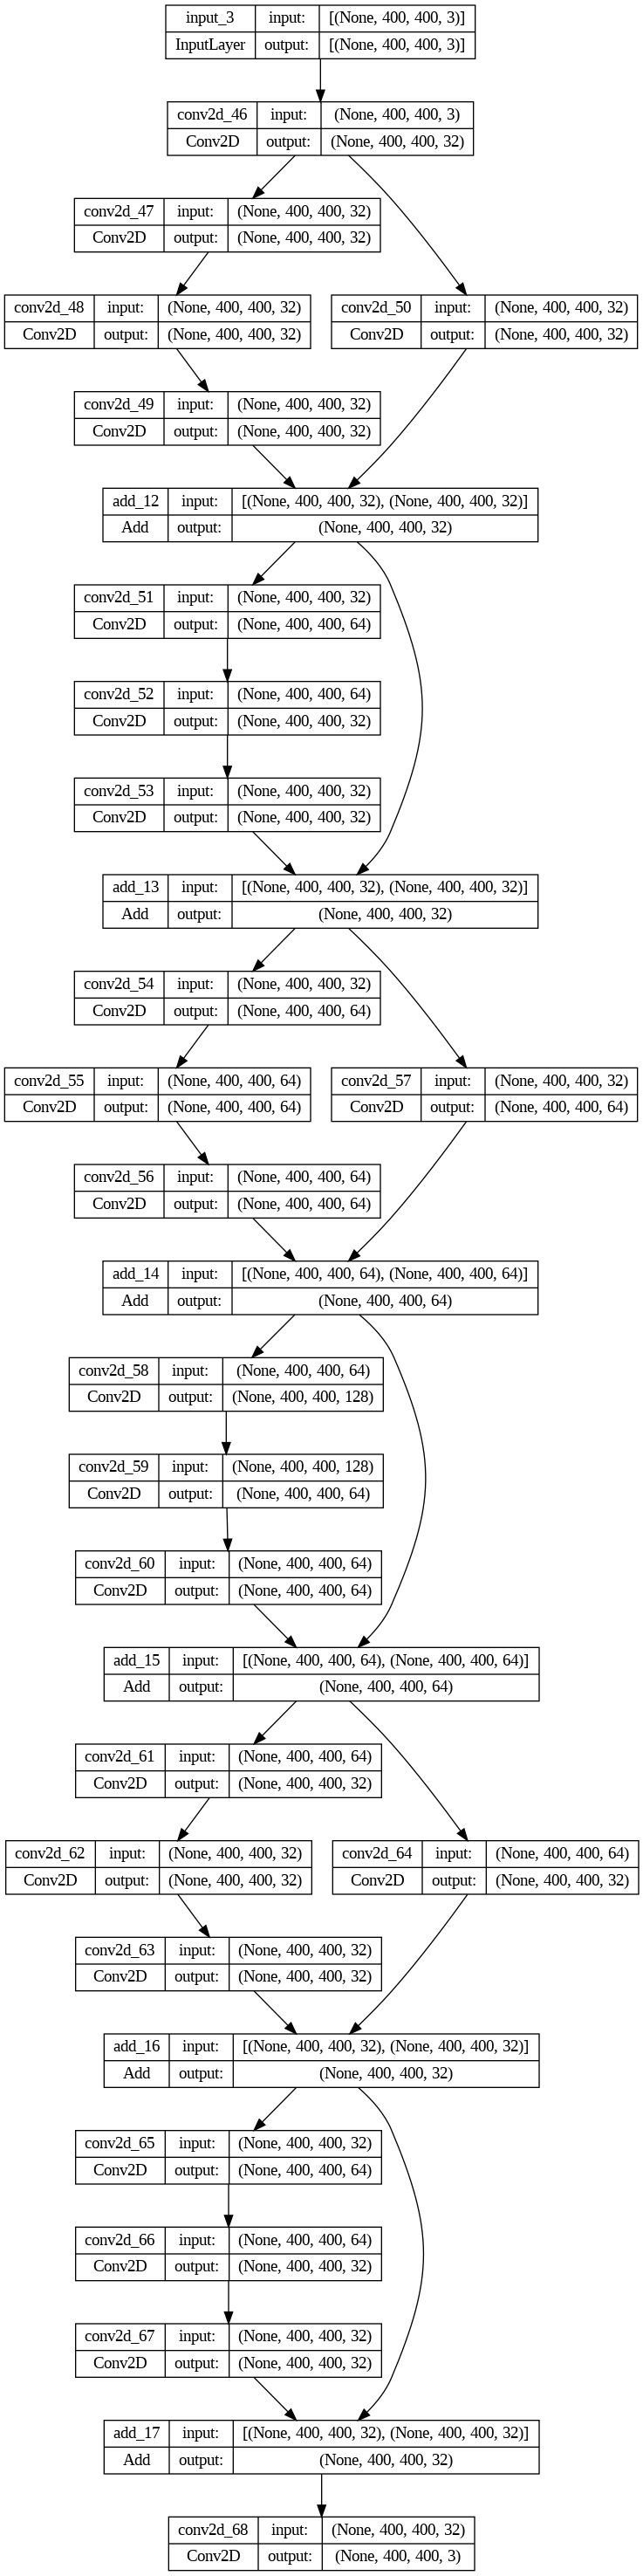

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(Model_Enhancer,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [ ]:
x, y = load_img(InputPath, train[:16])
x.shape, y.shape

In [15]:
Model_Enhancer.load_weights('Weights/')

## Model finetuning on LOL dataset

In [ ]:
import random
noise_dir = "/content/drive/MyDrive/Datasets/LowLight/our485/low/"
img_dir = "/content/drive/MyDrive/Datasets/LowLight/our485/high/"
img_list = os.listdir(img_dir)
img_list = np.array(img_list)
val = random.choices(img_list, k=50)
key = [x not in val for x in img_list]
train = img_list[key]
len(train), len(val)

(437, 50)

In [ ]:
img = cv.imread(img_dir+train[78])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.resize(img,(400, 600))
img.shape

(600, 400, 3)

In [ ]:
# Dataloader

def load_img(img_dir, noise_dir, img_list):
    images=[]
    noisy_images = []
    for i, image_name in enumerate(img_list):
        try:
            img = cv.imread(img_dir+image_name)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img,(400, 400))
            img = np.array(img/255.0, dtype = np.float32)
            img_transformed = cv.imread(noise_dir+image_name)
            img_transformed = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img_transformed = cv.resize(img,(400, 400))
            img_transformed = np.array(img/255.0, dtype = np.float32)
            images.append(img)
            noisy_images.append(img_transformed)
        except:
            pass
    images = np.array(images)
    noisy_images = np.array(noisy_images)

    return(noisy_images, images)

def imageLoader(img_dir, noise_dir, img_list, batch_size):

    L = len(img_list)

    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X, Y = load_img(img_dir, noise_dir, img_list[batch_start:limit])
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

In [ ]:
# def GenerateInputs(X,y):
#     for i in range(len(X)):
#         X_input = X[i].reshape(1,500,500,3)
#         y_input = y[i].reshape(1,500,500,3)
#         yield (X_input,y_input)
batch_size = 16
steps_per_epoch = len(train)//batch_size
val_steps_per_epoch = len(val)//batch_size
train_img_datagen =imageLoader(img_dir, noise_dir, train, batch_size)
val_img_datagen = imageLoader(img_dir, noise_dir, val, batch_size)

checkpoint_best = tf.keras.callbacks.ModelCheckpoint(filepath = "/content/drive/MyDrive/Datasets/Images/Weights/" , save_weights_only=True,
                                                     verbose = 1, #save_frequency = 'epoch')
                                                      monitor = 'val_loss', save_best_only = True, mode = 'min')
stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                      patience = 5, mode = 'min')


In [ ]:
history = Model_Enhancer.fit(train_img_datagen, steps_per_epoch = steps_per_epoch, epochs = 35,
                                    validation_data = val_img_datagen, validation_steps = val_steps_per_epoch,
                                    callbacks = [checkpoint_best, stop])

Epoch 1/35
27/27 [==============================] - ETA: 0s - loss: 0.1527 - peak_signal_noise_ratio: 19.0089 - ssim: 0.7993
Epoch 1: val_loss improved from inf to 0.08854, saving model to /content/drive/MyDrive/Datasets/Images/Weights/
27/27 [==============================] - 36s 452ms/step - loss: 0.1527 - peak_signal_noise_ratio: 19.0089 - ssim: 0.7993 - val_loss: 0.0885 - val_peak_signal_noise_ratio: 21.2460 - val_ssim: 0.8926
Epoch 2/35
27/27 [==============================] - ETA: 0s - loss: 0.0615 - peak_signal_noise_ratio: 24.3075 - ssim: 0.9077
Epoch 2: val_loss improved from 0.08854 to 0.02781, saving model to /content/drive/MyDrive/Datasets/Images/Weights/
27/27 [==============================] - 13s 380ms/step - loss: 0.0615 - peak_signal_noise_ratio: 24.3075 - ssim: 0.9077 - val_loss: 0.0278 - val_peak_signal_noise_ratio: 28.1433 - val_ssim: 0.9351
Epoch 3/35
27/27 [==============================] - ETA: 0s - loss: 0.0222 - peak_signal_noise_ratio: 29.3924 - ssim: 0.9448
E

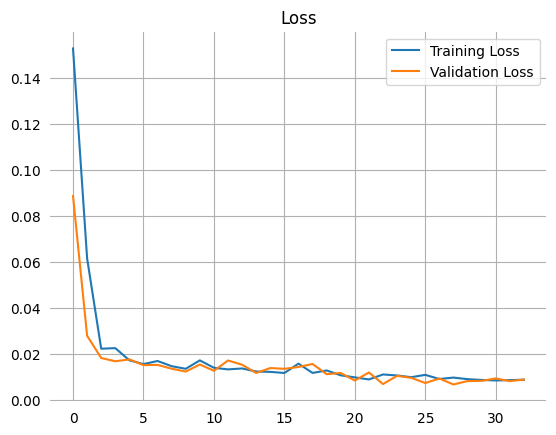

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.grid()
plt.legend()

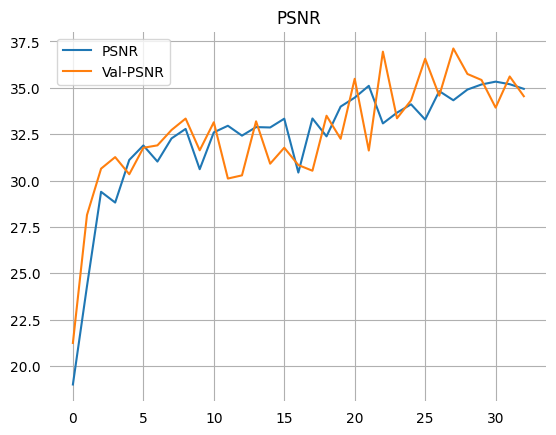

In [ ]:
plt.plot(history.history['peak_signal_noise_ratio'], label='PSNR')
plt.plot(history.history['val_peak_signal_noise_ratio'], label='Val-PSNR')
plt.title('PSNR')
plt.grid()
plt.legend()

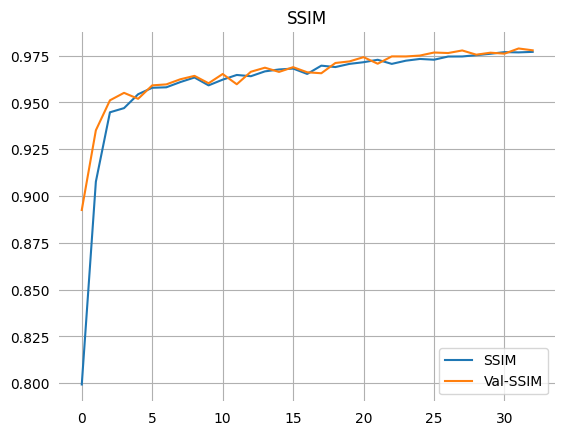

In [ ]:
plt.plot(history.history['ssim'], label='SSIM')
plt.plot(history.history['val_ssim'], label='Val-SSIM')
plt.title('SSIM')
plt.grid()
plt.legend()

In [ ]:
Model_Enhancer.save_weights("/content/Models/")

In [ ]:
TestPath="/content/drive/MyDrive/Datasets/LowLight/eval15/low/"

In [ ]:
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img,(256, 256))
    img = np.array(img/255.0, dtype= np.float32)
    gamma = random.choice([2,3,4,5])
    Noise = noisy(img, gamma)
    # Noise = noisy(Noise, noise_typ= 'gauss')
    # Noise = (Noise-Noise.min())/(Noise.max()-Noise.min())
    Noise = Noise.reshape(1,256, 256,3)
    return Noise

In [ ]:
ImagePath="/content/images/images/architecure/10110743246_82460e08e7_m.jpg"#TestPath+"0013.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)

In [ ]:
mpl.rcParams['axes.spines.left'] = False # Turn off the left axis
mpl.rcParams['axes.spines.right'] = False # Turn off the right axis
mpl.rcParams['axes.spines.bottom'] = False # Turn off the bottom axis
mpl.rcParams['axes.spines.top'] = False # Turn off the top axis
mpl.rcParams['xtick.bottom'] = False # Turn off the xticks
mpl.rcParams['ytick.left'] = False # Turn off the yticks

Prediction = Prediction.reshape(500,500,3)
#print(f'PSNR: {peak_signal_noise_ratio(image_for_test, Prediction).item()}')
plt.imshow((1/255)*Prediction)


In [ ]:
test_list = os.listdir(TestPath)

## COMPARATIVE ANALYSIS OF THE ENHANCED IMAGE WITH RESPECT TO GROUND TRUTH IMAGE

In [7]:
def PSNR(original, reconstructed):
    return tf.image.psnr(original, reconstructed, max_val=1.0)

In [8]:
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img,(400, 400))
    img = np.array(img/255.0, dtype= np.float32)
    Noise = img.reshape(1,400, 400,3)
    return Noise

1/1 [==============================] - 1s 690ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


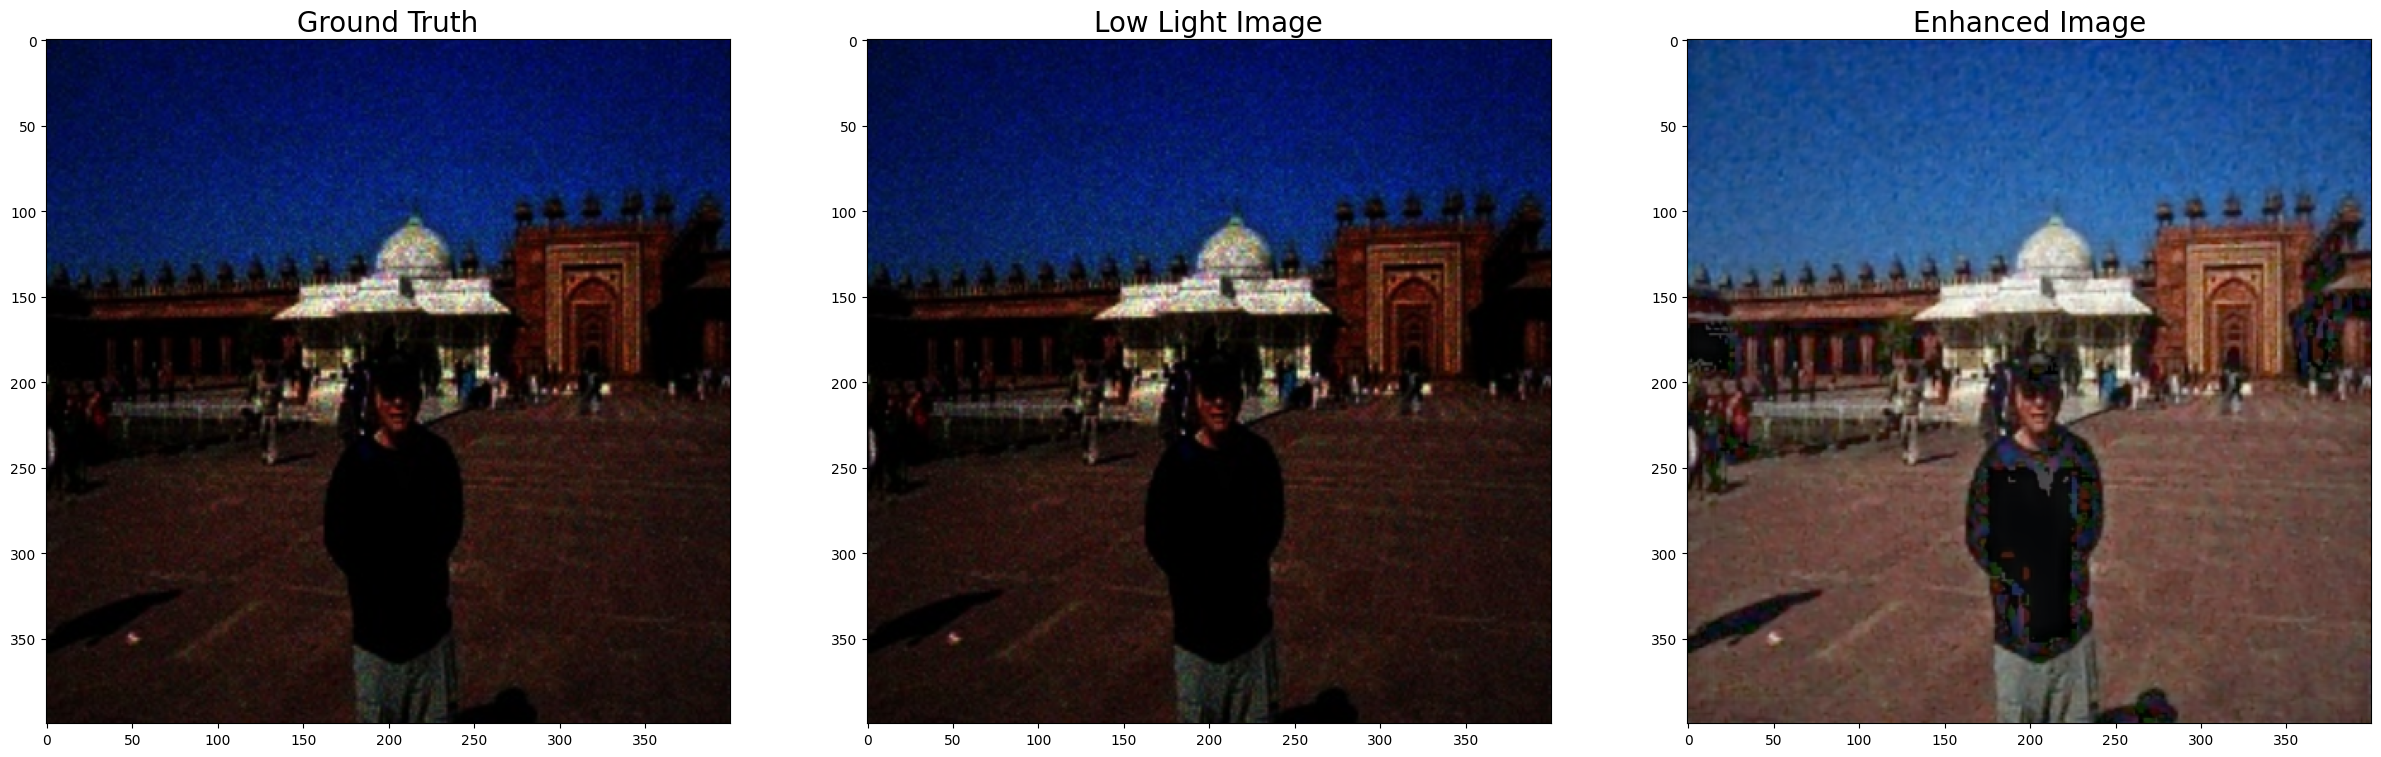

In [20]:

plt.figure(figsize=(30,30))
plt.subplot(1, 3 ,1)
img_1 = cv.imread(r"Samples/Places365_val_00006364.jpg")
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (400, 400))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(1, 3, 2)
img_ = ExtractTestInput(r"Samples/Places365_val_00006364.jpg")
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(400, 400,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(1, 3, 3)
Prediction = Prediction.reshape(400, 400,3)
plt.title("Enhanced Image",fontsize=20)
plt.imshow(Prediction)

1/1 [==============================] - 1s 750ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


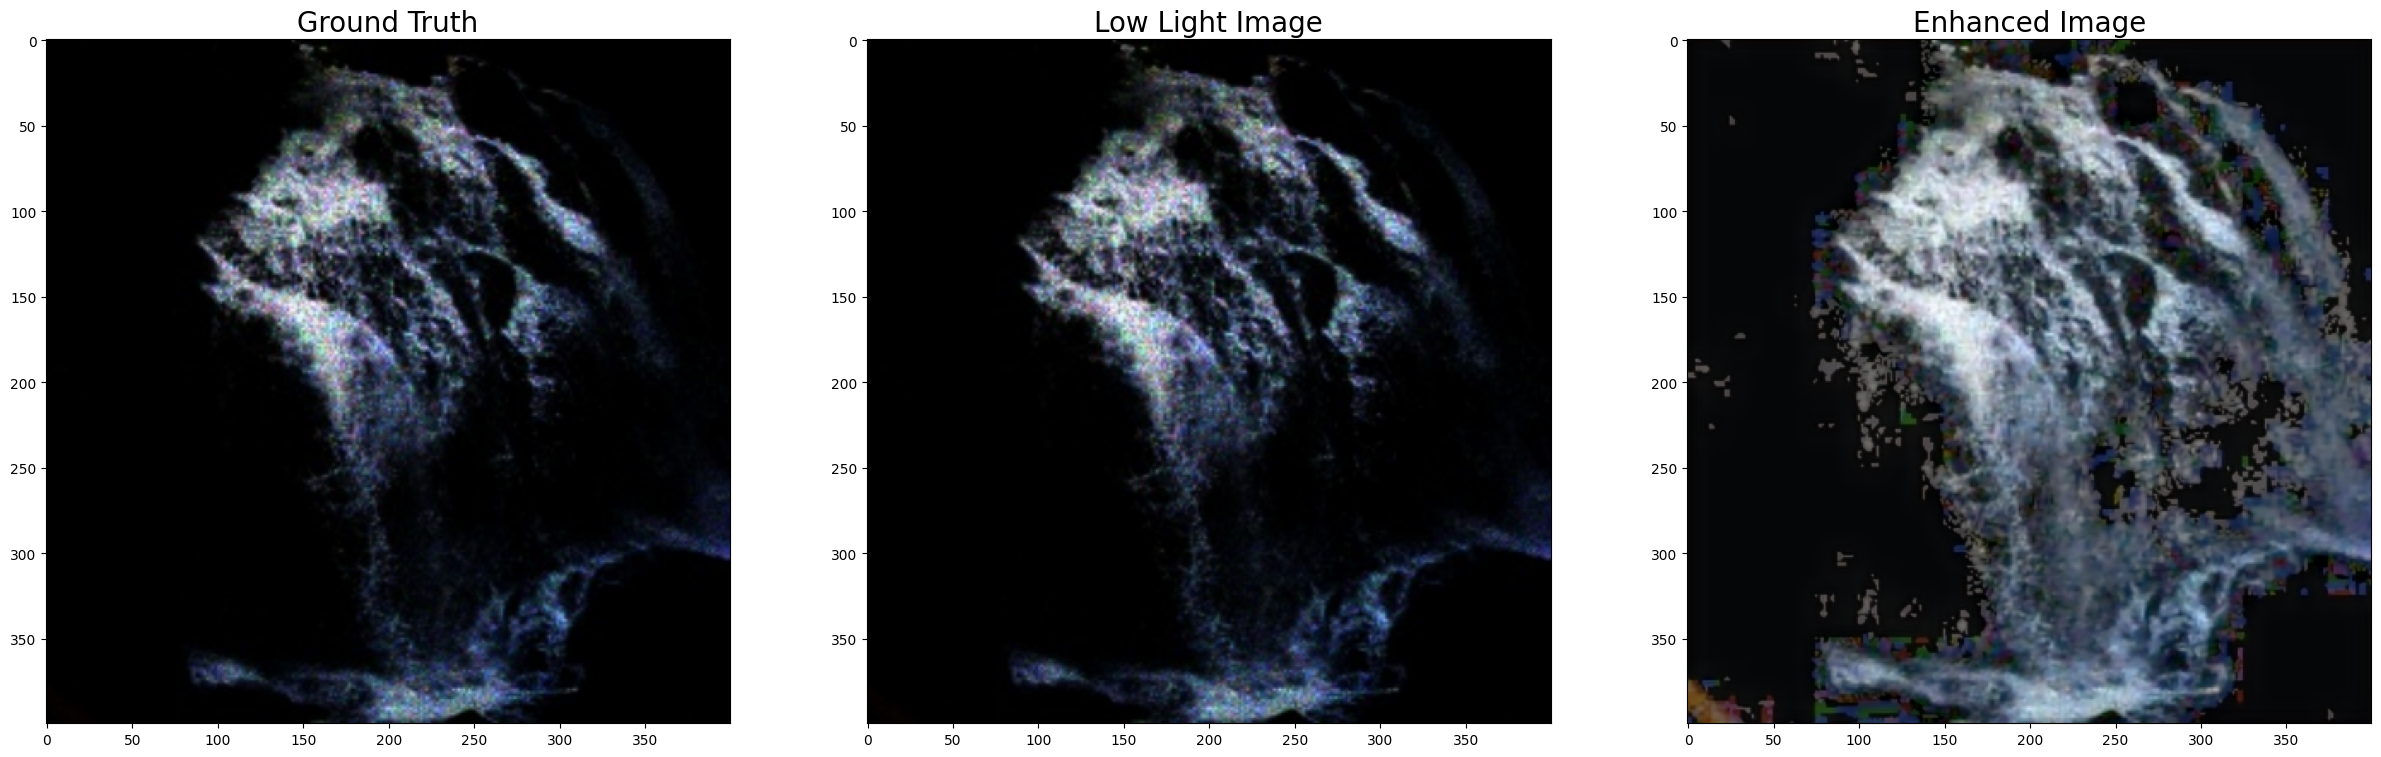

In [21]:

plt.figure(figsize=(30,30))
plt.subplot(1, 3 ,1)
img_1 = cv.imread("Samples/Places365_val_00011566.jpg")
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (400, 400))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(1, 3, 2)
img_ = ExtractTestInput("Samples/Places365_val_00011566.jpg")
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(400, 400,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(1, 3, 3)
Prediction = Prediction.reshape(400, 400,3)
plt.title("Enhanced Image",fontsize=20)
plt.imshow(Prediction)

### For live webcam video:

In [27]:
def enhance_webcam_feed(model_path, shape=(512, 512, 3)):
    # Start capturing video from the webcam
    cap = cv.VideoCapture(0)

    if not cap.isOpened():
        print("Error opening webcam")
        return

    # Read the first frame to get the frame size
    ret, frame = cap.read()
    if not ret:
        print("Failed to read frame from webcam")
        return

    # get the input shape of the model
    shape = frame.shape

    # Load the model
    model = create_model(shape)
    model.load_weights(model_path)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to RGB (OpenCV uses BGR by default), resize and process
        frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        frame_rgb = np.expand_dims(frame_rgb, axis = 0)

        enhanced_frame = model.predict(frame_rgb)

        # Reshape and convert back to BGR
        enhanced_frame = enhanced_frame.reshape(shape)
        enhanced_frame_bgr = cv.cvtColor(enhanced_frame.astype('uint8'), cv.COLOR_RGB2BGR)

        # Display the enhanced frame
        cv.imshow('Enhanced Webcam Feed', enhanced_frame_bgr)

        # Press Q to exit
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()
# Example usage
model_path = 'Weights/'

# Call the function to start the enhanced webcam feed
enhance_webcam_feed(model_path)


1/1 [==============================] - 1s 1s/step
